# Initialise
---

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload 
%autoreload 2
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from tqdm.auto import tqdm


# Fix della root del progetto --------------------------------------------------
print("\nFixing project root")
print(f'default sys.path: {sys.path}')
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir, '..')) # cheat fix
sys.path.append(PROJ_ROOT)
print(f'Project root: {PROJ_ROOT}')

# Importazione del modulo compass
QUESTIONS = ['globalisationinevitable', 'countryrightorwrong', 'proudofcountry', 'racequalities', 'enemyenemyfriend', 'militaryactionlaw', 'fusioninfotainment', 'classthannationality', 'inflationoverunemployment', 'corporationstrust', 'fromeachability', 'freermarketfreerpeople', 'bottledwater', 'landcommodity', 'manipulatemoney', 'protectionismnecessary', 'companyshareholders', 'richtaxed', 'paymedical', 'penalisemislead', 'freepredatormulinational', 'abortionillegal', 'questionauthority', 'eyeforeye', 'taxtotheatres', 'schoolscompulsory', 'ownkind', 'spankchildren', 'naturalsecrets', 'marijuanalegal', 'schooljobs', 'inheritablereproduce', 'childrendiscipline', 'savagecivilised', 'abletowork', 'represstroubles', 'immigrantsintegrated', 'goodforcorporations', 'broadcastingfunding', 'libertyterrorism', 'onepartystate', 'serveillancewrongdoers', 'deathpenalty', 'societyheirarchy', 'abstractart', 'punishmentrehabilitation', 'wastecriminals', 'businessart', 'mothershomemakers', 'plantresources', 'peacewithestablishment', 'astrology', 'moralreligious', 'charitysocialsecurity', 'naturallyunlucky', 'schoolreligious', 'sexoutsidemarriage', 'homosexualadoption', 'pornography', 'consentingprivate', 'naturallyhomosexual', 'opennessaboutsex']
# Fix della root del progetto --------------------------------------------------



# Importazione dei moduli per LLMs --------------------------------------------
print("\nImporting LLMs modules")
from huggingface_hub import login
os.environ["HUGGINGFACE_TOKEN"] = ""
login(token=os.environ["HUGGINGFACE_TOKEN"])

import torch
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
# If not, check if MPS is available
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
# If neither CUDA nor MPS is available, use CPU
else:
    device = torch.device("cpu")
    print("Using CPU")

# Test the device
x = torch.ones(1, device=device)
print(x)
# Importazione dei moduli per LLMs --------------------------------------------


Fixing project root
default sys.path: ['/Users/uqpberna/miniconda3/envs/personas/lib/python312.zip', '/Users/uqpberna/miniconda3/envs/personas/lib/python3.12', '/Users/uqpberna/miniconda3/envs/personas/lib/python3.12/lib-dynload', '', '/Users/uqpberna/miniconda3/envs/personas/lib/python3.12/site-packages', '/Users/uqpberna/miniconda3/envs/personas/lib/python3.12/site-packages/setuptools/_vendor']
Project root: /Users/uqpberna/Documents/Code/ASPD_Generator/src

Importing LLMs modules
Using MPS
tensor([1.], device='mps:0')


# Load dataframes
---

In [4]:
models = ['Mistral-7B-Instruct-v0.3', 'Llama-3.1-8B-Instruct', 'Qwen2.5-7B-Instruct', 'zephyr-7b-beta']

dfs = {}

for model in models:
    df = pd.read_parquet(f'/Users/uqpberna/Documents/Code/ASPD_Generator/data/processed/{model}/base/persona_compass.pqt')
    df['compass_position'] = df['compass_position'].apply(lambda x: (x[0], x[1]))
    dfs[model] = df[['persona_id', 'compass_position']].drop_duplicates().reset_index(drop=True)

# Plot distributions with marginals
---

In [169]:
def plot_compass_density(df, bins=None, gridsize=30, label_gap=1.5, label_margin=0.15, 
                      marginal_ratio=12, tick_interval=2, scientific_notation=True,
                      label_size=10, tick_size=8, colorbar_size=8, marginal_alpha=0.5,
                      origin_lines_alpha=0.8):
    """
    Plot the compass density with controllable label spacing, marginal size, and formatting options.
    Modified version with combined -10 label at the origin, configurable center lines, and full borders.
    
    Parameters:
    -----------
    [previous parameters remain the same]
    marginal_alpha : float, optional (default=0.5)
        The alpha (transparency) value for the marginal distribution plots
    origin_lines_alpha : float, optional (default=0.8)
        The alpha (transparency) value for the center (origin) lines
    """
    # Extract x and y coordinates from the compass_position tuples
    x_coords = [pos[0] for pos in df['compass_position']]
    y_coords = [pos[1] for pos in df['compass_position']]
    
    # Create the joint plot with adjusted heights
    g = sns.JointGrid(x=x_coords, y=y_coords, 
                      height=8,
                      ratio=marginal_ratio,
                      marginal_ticks=True,
                      space=label_margin)
    
    # Add the scatter plot with hexbin
    hexbin = g.ax_joint.hexbin(
        x_coords, 
        y_coords,
        gridsize=gridsize,
        cmap='YlOrRd',
        mincnt=1,
        bins=bins,
        extent=(-10, 10, -10, 10)
    )
    
    # Add the marginal distributions with the specified alpha
    g.plot_marginals(sns.histplot, bins=gridsize, color='#FF6B6B', alpha=marginal_alpha)
    
    # Set figure size
    g.figure.set_size_inches(10, 10)
    
    # Set the axis limits and ticks for the main plot
    g.ax_joint.set_xlim(-10, 10)
    g.ax_joint.set_ylim(-10, 10)
    
    # Set tick intervals
    ticks = np.arange(-10, 11, tick_interval)
    g.ax_joint.set_xticks(ticks)
    g.ax_joint.set_yticks(ticks)

    # Set minor grid lines
    grid_lines = np.arange(-10, 11, 1)
    g.ax_joint.set_xticks(grid_lines, minor=True)
    g.ax_joint.set_yticks(grid_lines, minor=True)

    # Show all spines (borders)
    for spine in ['top', 'right', 'left', 'bottom']:
        g.ax_joint.spines[spine].set_visible(True)
        g.ax_joint.spines[spine].set_color('black')
        g.ax_joint.spines[spine].set_linewidth(1.2)

    # Also show spines for marginal plots
    # for spine in ['top', 'right', 'left', 'bottom']:
    #     g.ax_marg_x.spines[spine].set_visible(True)
    #     g.ax_marg_x.spines[spine].set_color('black')
    #     g.ax_marg_x.spines[spine].set_linewidth(1.2)
    #     g.ax_marg_y.spines[spine].set_visible(True)
    #     g.ax_marg_y.spines[spine].set_color('black')
    #     g.ax_marg_y.spines[spine].set_linewidth(1.2)

    # Custom formatter function for axis ticks
    def custom_formatter(x, p):
        if x == -10:
            return ''  # Remove -10 from both axes
        if abs(x) >= 1000:
            return f'{int(x/1000)}k'
        return str(int(x))
    
    # Apply custom formatter to main plot
    g.ax_joint.xaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
    g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
    
    # Custom formatter for marginal plots
    def format_thousand_ticks(x, p):
        if abs(x) >= 1000:
            return f'{int(x/1000)}k'
        return str(int(x))
    
    # Apply custom formatter to marginal plots
    g.ax_marg_x.yaxis.set_major_formatter(plt.FuncFormatter(format_thousand_ticks))
    g.ax_marg_y.xaxis.set_major_formatter(plt.FuncFormatter(format_thousand_ticks))
    
    # Set tick label size
    g.ax_joint.tick_params(axis='both', labelsize=tick_size)
    g.ax_marg_x.tick_params(axis='both', labelsize=tick_size)
    g.ax_marg_y.tick_params(axis='both', labelsize=tick_size)
    
    # Remove default axis labels
    g.ax_joint.set_xlabel('')
    g.ax_joint.set_ylabel('')
    
    # Adjust margins based on label_gap
    margin_size = label_gap / 20
    plt.subplots_adjust(left=0.15 + margin_size, bottom=0.15 + margin_size)
    
    # Calculate label positions based on gap
    label_pos = 10 + label_gap
    
    # Add labels with transforms to ensure they're outside the plot
    # For X-axis
    g.ax_joint.text(-10, -label_pos, '← Left', ha='left', va='top', 
                    transform=g.ax_joint.transData, fontsize=label_size)
    g.ax_joint.text(10, -label_pos, 'Right →', ha='right', va='top', 
                    transform=g.ax_joint.transData, fontsize=label_size)
    
    # For Y-axis
    g.ax_joint.text(-label_pos, 10, 'Authorit. →', ha='right', va='top', 
                    rotation=90, transform=g.ax_joint.transData, fontsize=label_size)
    g.ax_joint.text(-label_pos, -10, '← Libert.', ha='right', va='bottom', 
                    rotation=90, transform=g.ax_joint.transData, fontsize=label_size)
    
    # Add the -10 label in the bottom left corner
    g.ax_joint.text(-10.3, -10.3, '-10', ha='right', va='top', 
                    transform=g.ax_joint.transData, fontsize=tick_size)
    
    # Add colorbar
    joint_pos = g.ax_joint.get_position()
    cbar_width = 0.03

    # Get the position of the right marginal plot
    marg_right_pos = g.ax_marg_y.get_position()

    # Position colorbar
    cax = g.figure.add_axes([
        marg_right_pos.x1 + 0.04,
        joint_pos.y0,
        cbar_width,
        joint_pos.height
    ])

    # Add colorbar with appropriate number format
    cbar = g.figure.colorbar(hexbin, cax=cax, label='')
    if not scientific_notation:
        cbar.formatter.set_powerlimits((0, 0))  # Force regular notation
    cbar.ax.tick_params(labelsize=colorbar_size)
    cbar.update_ticks()
    
    # Add grid lines
    g.ax_joint.grid(True, which='major', linestyle='-', alpha=0.7)  # Major grid lines
    g.ax_joint.grid(True, which='minor', linestyle='--', alpha=0.7)
    
    # Add center lines with configurable opacity
    g.ax_joint.axhline(y=0, color='k', linestyle='-', alpha=origin_lines_alpha, linewidth=1.5)
    g.ax_joint.axvline(x=0, color='k', linestyle='-', alpha=origin_lines_alpha, linewidth=1.5)
    
    return g

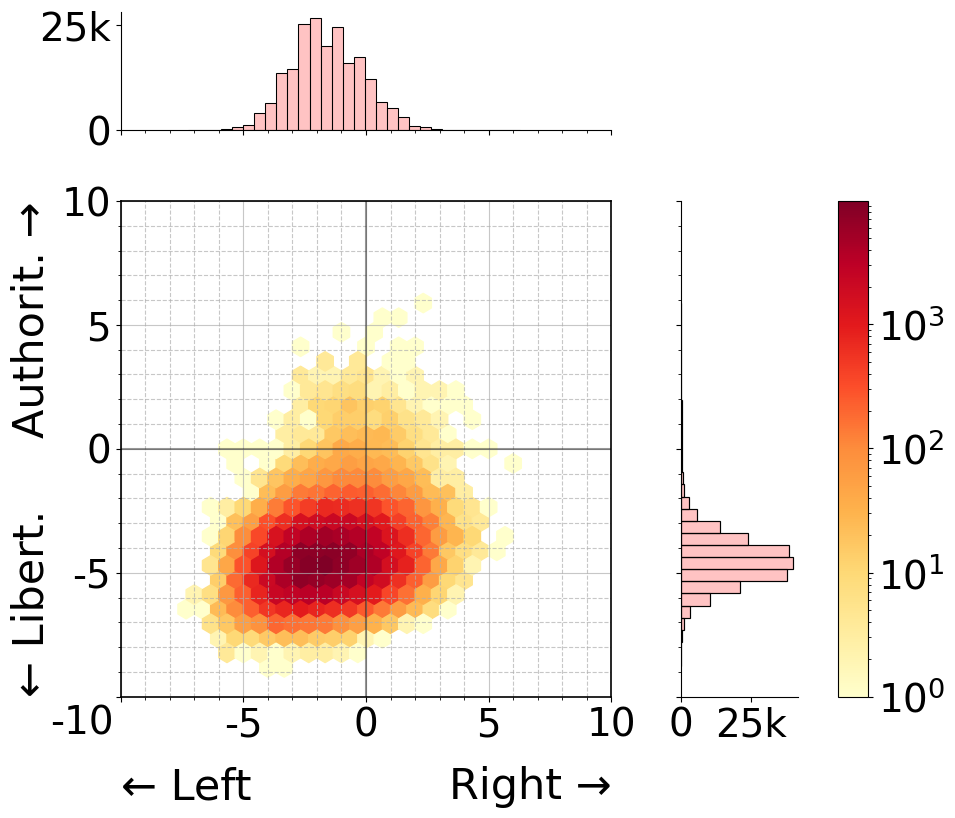

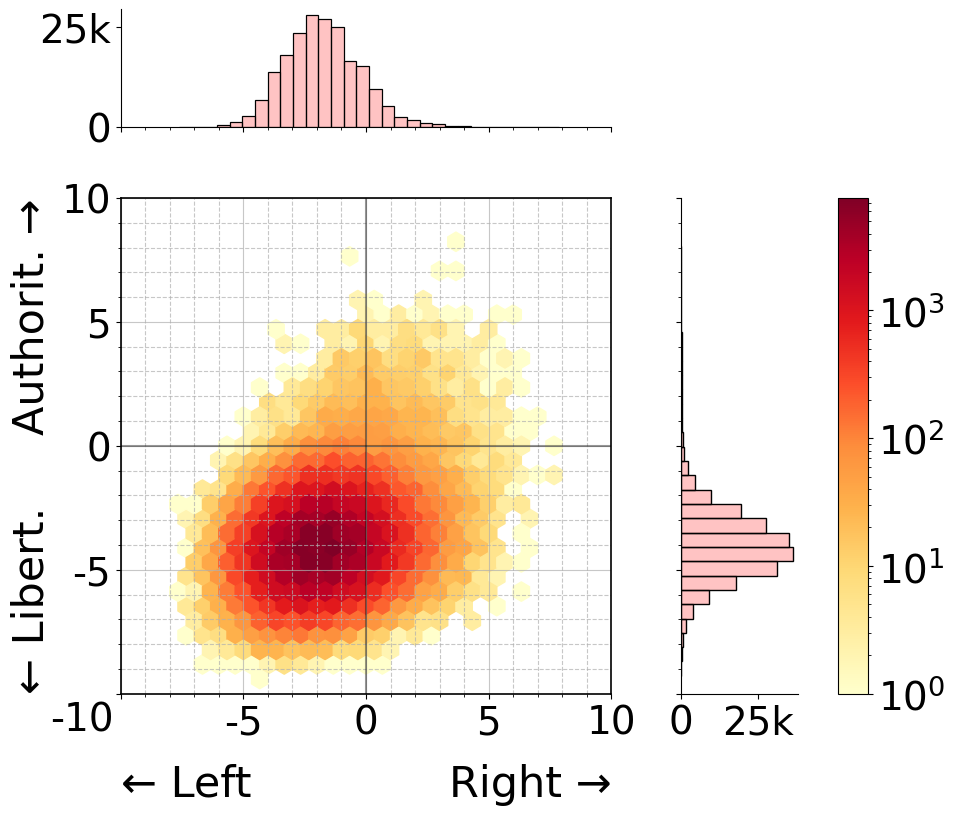

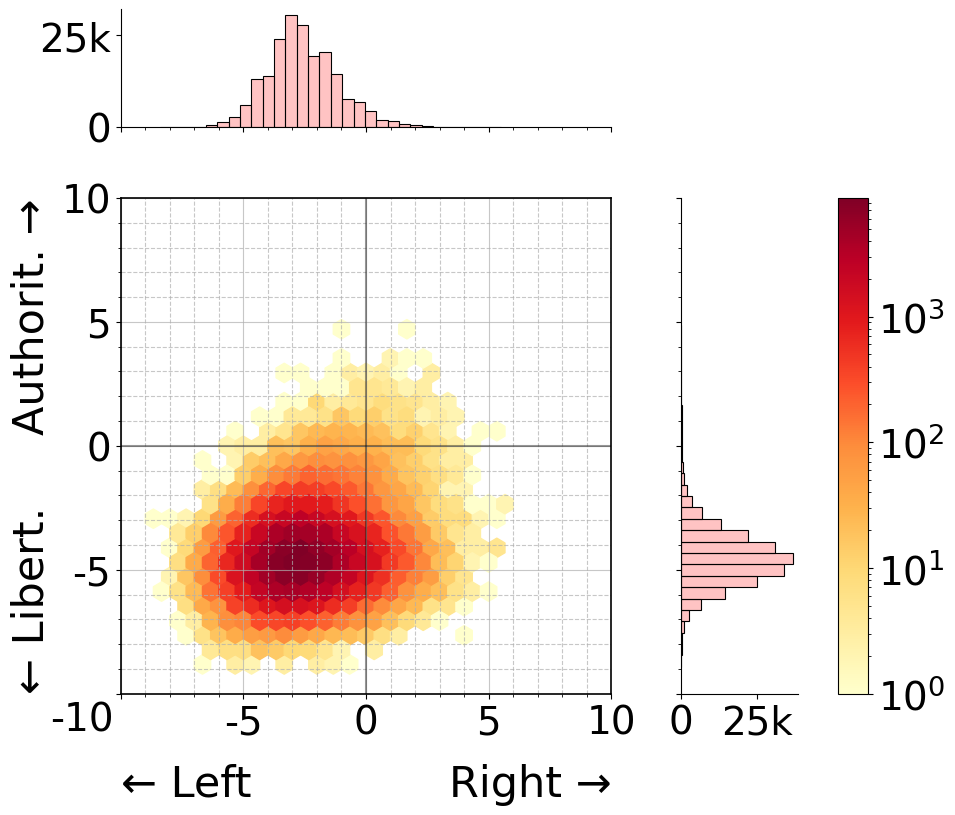

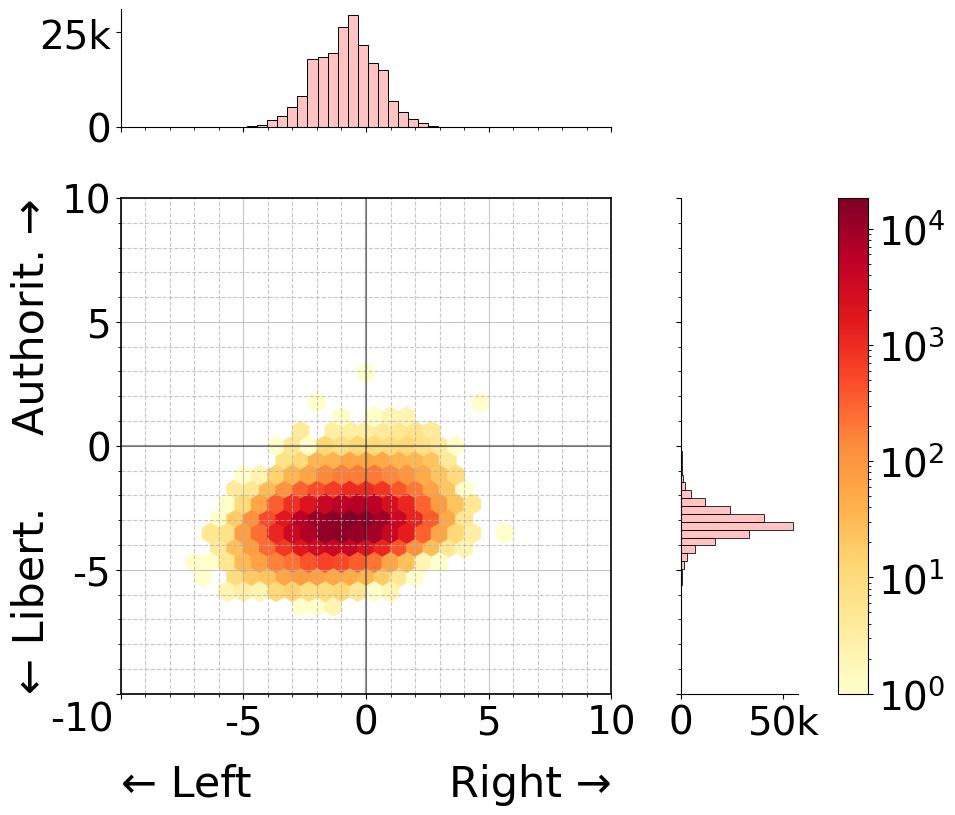

In [170]:
for model in models:
    l = plot_compass_density(dfs[model], bins='log', gridsize=30, label_gap=2.8, 
                             label_margin=0.6, marginal_ratio=3, tick_interval=5, 
                             label_size=31, tick_size=28, colorbar_size=28, marginal_alpha=0.4, origin_lines_alpha=0.4)
    l.savefig(f'/Users/uqpberna/Documents/Code/ASPD_Generator/images/{model}/base/compass_density_log_{model}.png')
    plt.show()

# Movement between models
---

In [171]:
# Use the dataframes to calulate a lower diagonal matrix 4 x 4
# The matrix will contain the mean of the euclidean distance between the personas of the two models

matrix = np.zeros((4, 4))

for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        if i < j:
            dist = euclidean_distances(dfs[model1]['compass_position'].tolist(), dfs[model2]['compass_position'].tolist())
            matrix[i, j] = dist.mean()
            matrix[j, i] = dist.mean()

print(matrix)

: 